# Grupiranje krivulja vremenskih serija - dana i tjedana
Prije korištenja osigurati da su tjedni u dataframeu potpuni, s konstantnom frekvencijom i datetime indeksom!

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import random
from collections import Counter

In [19]:
def checkFullWeeks(df):
    """
    Provjerava sadrzi li df potpune tjedne i vraca df s poptunim tjednima
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
    Returns:
        novi dataframe brojem dana djeljivim sa 7 (odnosno s punim tjednima)
    """
    if df.empty:
        return df
    min_date = df.index.min()
    max_date = df.index.max()           
    num_days = (max_date - min_date).days + 1
    num_weeks = num_days // 7
    if num_days % 7 == 0:
        return df 
    days_to_remove = num_days % 7
    df = df.iloc[days_to_remove:]
    return df_fixed

In [2]:
def read_csv(file, columns, timecolumn):
    """funkcija za čitanje podataka vremenske serije.
    Args:
        file(str): putanja do csv datoteke
        columns(list of str): značajke
        timecolumn(str): značajka vremena
    Returns:
         učitani dataframe
    """
    df = pd.read_csv(file,usecols=columns, parse_dates=[timecolumn], encoding='latin1')
    return df

Primjer kreiranja dataframea za sve mjesece 2023

In [5]:
combined_df = pd.DataFrame()

for i in range(1,13):
        file = r"bojler_{}_{}-filled.csv".format(i,2023)
        df = read_csv(file, columns=['time','total_active_power'], timecolumn='time')
        df=df.set_index('time')
        data_hourly = df['total_active_power'].resample('15T').mean()
        combined_df = pd.concat([combined_df, data_hourly], axis=0)
combined_df.rename(columns={combined_df.columns[0]:'total_active_power'},inplace=True)


C:\Users\matea\AppData\Local\Temp\ipykernel_4584\2522371466.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_df = pd.concat([combined_df, data_hourly], axis=0)


In [20]:
df = checkFullWeeks(combined_df)

In [7]:
def get_day(day):
    if day<5:
        #radni
        return 1
    else:
        #neradni
        return 0
day_values = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4:'friday', 5:'saturday', 6:'sunday'}
color_map = {group: color for group, color in zip(range(1, 7), ['r', 'g', 'b', 'c', 'm', 'y'])}

# Stvaranje primjera s odgovarajućim brojem značajki

In [35]:
def prepareWeekData(df, column, data_frequency):    
    """
    Priprema podatke za algoritam K sredina, slaže retke od odgovarajućeg broja značajki.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        column (str): značajka
        data_frequency (int): period podataka u sekundama, za T=15min -> 15*60    
    """
    t = int(24 * 7 * 3600/data_frequency)
    df.loc[:,'week'] = combined_df.index.isocalendar().week
    l = df[column].tolist()
    listt = []
    for i in range(df['week'].nunique()):
        listt.append(l[0 + i * t:(i + 1) * t])
    d2 = np.array(listt)
    return d2

In [36]:
d = prepareWeekData(df, 'total_active_power', 15*60)

In [32]:
def prepareDayData(df, column, data_frequency):    
    df.loc[:,'day'] = df.index.dayofyear
    df.loc[:,'working'] = df.index.day_of_week.map(get_day)
    t = int(24 * 3600/data_frequency)
    l = df[column].tolist()
    listt = []
    for i in range(df['day'].nunique()):
        listt.append(l[0 + i * t:(i + 1) * t])
    d1 = np.array(listt)
    return d1

In [33]:
d1 = prepareDayData(df, 'total_active_power', 15*60)

# Iscrtavanje funkcije pogreške

In [ ]:
def plotJ(d, iter, K, method):
    """
    Iscrtava graf ovisnosti pogreške grupiranja o broju grupa.
    Args:
        d (np.array): matrica sa značajkama i primjerima koji se grupiraju, prije pozvati prepareWeekData
        iter (int): broj neovisnih krivulja pogreške 
        K (int): maksimalan broj grupa
        method (str): Metoda grupiranja, K-sredina s euklidskom udaljenoscu ili DTW-om; "euclid" ili "dtw"
    """
    fig, ax = plt.subplots()
    for iteration in range(iter):
        j = []
        for k in range(1,K+1):
            if method == "euclid":
                kmeans = KMeans(n_clusters=k).fit(d)
            elif method == "dtw":
                kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw").fit(d)
            
            j.append(kmeans.inertia_)
        ax.plot(range(1, K+1), j, c=color_map[iteration % len(color_map) + 1], label=f'{iteration + 1}. pokretanje')
        ax.scatter(range(1, K+1), j, c=color_map[iteration % len(color_map) + 1])
    ax.set_title(f'Ovisnost pogreške grupiranja o broju grupa - {method}')
    ax.set_xlabel('broj grupa')
    ax.set_ylabel('greška')
    ax.legend()
    plt.show()

In [ ]:
plotJ(d, 1, 3, "dtw")

In [ ]:
plotJ(d1, 1, 3, "dtw")

# Izračun grupa:

In [40]:
def calcClusters(d, k, method):
    """
    Args:
         d (np.array): matrica sa značajkama i primjerima koji se grupiraju, prije pozvati prepareWeekData
         k(int): broj grupa
         method(str): metoda izračuna udaljenosti, 'euclid' ili 'dtw'
    """
    if method == "euclid":
        kmeans = KMeans(n_clusters=k)
        groups = kmeans.fit_predict(d)
        centers = kmeans.cluster_centers_
    elif method == "dtw":
        kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw")
        groups = kmeans.fit_predict(d)
        centers = kmeans.cluster_centers_
    return kmeans, groups    


# Grafički prikaz svih primjera jedne grupe i centroida

In [38]:
def plotAllSamplesAndCenters(d, kmeans, groups, data_frequency):
    """
    Grafički prikaz svih tjedana u grupi s njihovim centroidom
    Args:
        d (np.array): matrica sa značajkama i primjerima koji se grupiraju, prije pozvati prepareWeekData
        kmeans: instanca algortima kmeans, pozvati caclClusters 
        groups: polje dimenzije svih primjera s pripadnostima grupama, pozvati caclClusters 
        data_frequency (int): period podataka u sekundama, za T=15min -> 15*60    
    """
    t = int(24 * 7 * 3600/data_frequency)
    centers = kmeans.cluster_centers_
    for group in np.unique(groups):
        plt.figure(figsize=(12,6))
        c=0
        g = groups == group
        all = []
        for idx, is_in_group in enumerate(g):
            if is_in_group:
                c+=1
                points = d[idx][:t]
                if(c==1):
                    plt.plot(points, color='gray',alpha=0.4, label='primjeri grupe')
                else:
                    plt.plot(points, color='gray',alpha=0.4)
                all.append(points)
        if group < len(centers):
            plt.plot(centers[group], color='red', label='centroid grupe')
        plt.xlabel('vrijeme', fontsize=18)
        plt.ylabel('snaga / W', fontsize = 18)
        plt.title('Grupa {}'.format(group), fontsize=18)
        plt.legend(fontsize=18)
        plt.tick_params(axis='x', labelsize=18)
        plt.tick_params(axis='y', labelsize=18)

    plt.show()

In [43]:
kmeans, grupe = calcClusters(d,2,"dtw")


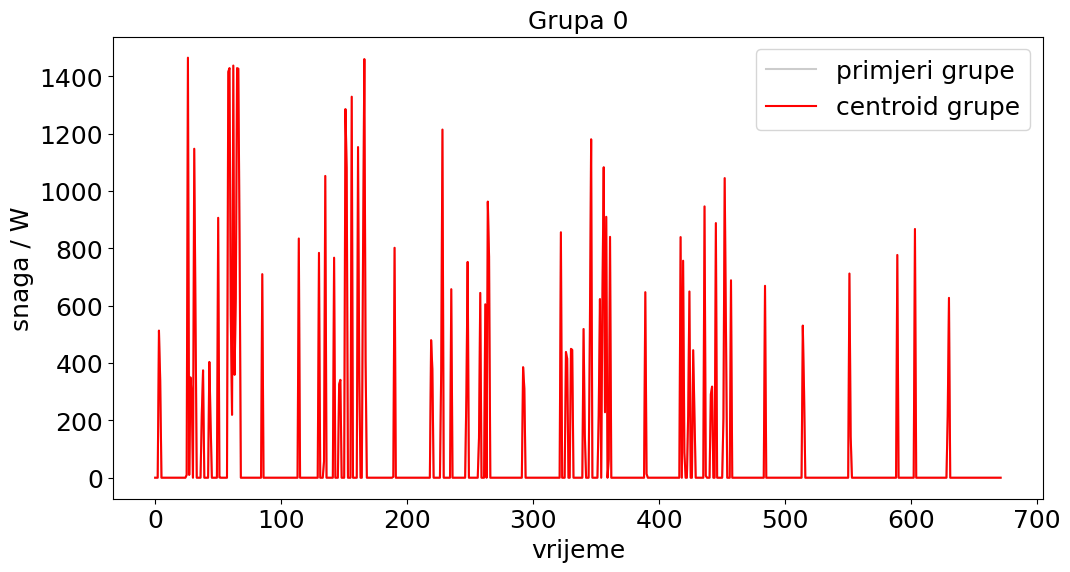

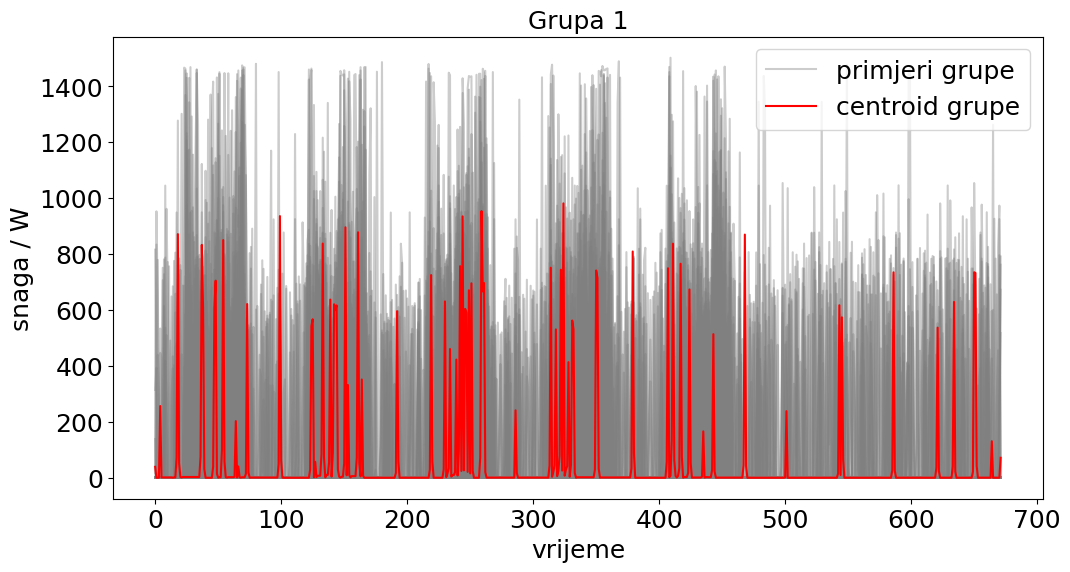

In [44]:

plotAllSamplesAndCenters(d, kmeans, grupe,15*60)

In [ ]:
kmeans1, grupe1 = calcClusters(d1,2,"dtw")

In [ ]:
plotAllSamplesAndCenters(d1,kmeans1, grupe1, 15*60)

# Grafički prikaz pripadnosti primjera grupama

In [ ]:
 def plotSamplesByGroup(groups, r=None, type=None):
    """
    Iscrtava pripadnost pojednih primjera grupama.
    Args:
        groups(array): polje dimenzije svih primjera s pripadnostima grupama, pozvati caclClusters
        r (list of int): interval odnosno redni brojevi dana/tjedana (u dataframeu, ne kroz godinu) koji se iscrtavaju
        type(str): za 'days', rijec je o danima i bojaju se u radne i vikende
    """
    g = np.unique(groups)
    plt.figure(figsize=(10,5))
    if(r == None):
        r = range(len(groups))
        
    if type=='days':
        labels_added = set()
        ra = {0:'vikend', 1:'radni dan'}        
        for i in r:
            working_value = combined_df.iloc[i*4*24]['working']
            label = ra[working_value] if ra[working_value] not in labels_added else ""
            plt.scatter(i, groups[i], c=color_map[working_value+1], label=label)
            labels_added.add(ra[working_value])
        plt.legend(fontsize=18)

    else:
        for i in r:
            plt.scatter(i, groups[i], c=color_map[groups[i]+1], label=f'Group {groups[i]}' if i == list(groups).index(groups[i]) else "")
    plt.xlabel("redni broj primjera", fontsize=18)
    plt.title("pripadnost primjera grupi", fontsize=18)
    plt.ylabel("grupa", fontsize=18)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)

In [ ]:
plotSamplesByGroup(grupe)

In [ ]:
plotSamplesByGroup(grupe1, range(300,364), 'days')

# Iscrtavanje primjera iz različitih grupa i centroida različitih grupa

In [ ]:
def plotSamplesAndCenters(d, groups, centers, first, second):
    """
    Iscrtava nasumični tjedan/dana iz svake od zadanih grupa s centroidima, te centroide.
    Args:
        d (np.array): matrica sa značajkama i primjerima koji se grupiraju, prije pozvati prepareWeekData
        groups (array): polje dimenzije svih primjera s pripadnostima grupama, pozvati caclClusters 
        first (int): prva grupa čiji se dani/tjedni iscrtavaju
        second (int): druga grupa čiji se dani/tjedni iscrtavaju
    """
    label_counts = Counter(groups[(groups==first) | (groups==second)])
    r = random.randint(0,label_counts[min(label_counts, key = label_counts.get)])
    #data outside of group
    df = d[groups==first][r]
    df2 = d[groups==second][r]
    center1 = centers[first]
    center2 = centers[second]
    
    plotSeries(df,center1,first,first,'tc')
    plotSeries(df,center2,first,second,'tc')
    plotSeries(df2,center1,second,first,'tc')
    plotSeries(df2,center2,second,second,'tc')
    plotSeries(center1,center2,first,second,'c')

In [ ]:
def plotSeries(d1, d2, first, second, type):
    """
    Args:
        d1 (array): matrica sa značajkama i primjerima koji pripadaju prvoj grupi
        d2 (array): matrica sa značajkama i primjerima koji pripadaju prvoj grupi
        first (int): prva grupa čiji se tjedni iscrtavaju
        second (int): druga grupa čiji se tjedni iscrtavaju
        type (str): vrsta grafa, c za centroide, tc za tjedan i centroid
    """
    plt.figure(figsize=(20,6))
    if(type=='tc'):
        title = f"prikaz jednog primjera grupe {first} i centroida grupe {second}"
        l1 = f'primjer iz grupe {first}'
        l2 = f'centroid grupe {second}'
        c1='orange'
    elif type=='c':
        title = f"prikaz centroida grupa {first} i {second}"
        l1 = f'centroid grupe {first}'
        l2 = f'centroid grupe {second}'
        c1='blue'
    plt.plot(d1, label=l1, color=c1)
    plt.plot(d2, label=l2, color='c')
    plt.xlabel("redni broj trenutka", fontsize=18)
    plt.ylabel("snaga / W", fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="upper right")
    plt.legend(fontsize=14, loc='upper right')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)

In [ ]:
plotSamplesAndCenters(d, grupe, kmeans.cluster_centers_, 1,0)

In [ ]:
plotSamplesAndCenters(d1, grupe1, kmeans1.cluster_centers_, 0,1)